In [3]:
from datasets import load_dataset
import pandas as pd
from rank_bm25 import BM25Okapi
import numpy as np
from tqdm import tqdm
LANG_CODE = 'yo'
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')

c4 = load_dataset("allenai/c4", LANG_CODE)
c4_dev_dict = c4.data['validation'].to_pydict()
c4_train_dict = c4.data['train'].to_pydict()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chaosarium/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Generating train split: 46214 examples [00:00, 64908.12 examples/s]
Generating validation split: 42 examples [00:00, 11931.78 examples/s]


In [4]:
mabl_df = pd.read_csv(f'../langdata/{LANG_CODE}.csv')
# mabl_su_df = pd.read_csv('../translate-test/su.csv')
# mabl_su_df = pd.read_csv('../data/syntax_chunked/syntax_tagged_su.csv')

In [5]:
mabl_df

,startphrase,ending1,ending2,labels
0,Òkèlè ẹ̀bà mẹ́ẹ̀ẹ́dọ́gbọ̀n ni ọmọ náà jẹ...,Ọmọ náà jẹ oúnjẹ púpọ̀,Ọmọ náà kò jẹ oúnjẹ púpọ̀,0
1,Òkèlè ẹ̀bà kan ni ọmọ náà jẹ lánàá,Ọmọ náà jẹ oúnjẹ púpọ̀,Ọmọ náà kò jẹ oúnjẹ púpọ̀,1
2,Ó burú bí i àjẹ́ apọmọjẹ,Ó máa ń rẹ́rìn-ín,Ó níkà gan,1
3,Ó burú bí i ọlọ́kàn rere,Ó máa ń rẹ́rìn-ín,Ó níkà gan,0
4,Òrùn náà ń fẹyín síta bí i ọmọ jòjòló,Ilẹ̀ mọ́ kedere,Òkùnkún bolẹ̀ kan.,0
...,...,...,...,...
725,O ti tún ìdí rẹ̀ ṣe,Ó ti fi nǹkan kẹ́reré kóbá ara rẹ̀,Ó ti fi nǹkan ńlá tún ayé ara rẹ̀ ṣe,0
726,Ó ń gbé mi gẹṣin aáyán,Ó ń ṣe ìlérí irọ́ fún mi,Ó ń ṣe ìlérí òtítọ́ fún mi,1
727,Ó ń gbé mi gẹṣin tọ́ba ìlú wa ṣẹ̀ṣẹ̀ rà,Ó ń ṣe ìlérí irọ́ fún mi,Ó ń ṣe ìlérí òtítọ́ fún mi,0
728,Àjàdí ló su sáwo,Àjàdí ló ba nǹkan jẹ́,Àjàdí ló tún nǹkan ṣe,1


In [6]:
start_phrases = mabl_df['startphrase'].tolist()
ending1s = mabl_df['ending1'].tolist()
ending2s = mabl_df['ending2'].tolist()

In [7]:
figqa_examples = list(map(lambda tri: f"{tri[0]} {tri[1]} {tri[2]}".replace(".", "").replace(",", ""), zip(start_phrases, ending1s, ending2s)))

In [8]:
c4_dev_dict['text'][:5]

['Testosterone ni Thailand - Nebido 1000 mg / 4 milimita 1X4 milimita\nNebido 1000 mg / 4 milimita 1x4 (Testosterone)\nBayer Tọki\ndeede owo 0.00 ฿ 0.00 ฿ sale\nOlupese: Bayer\nOhun ti o nṣiṣe lọwọ: Awọn injections ti iṣan ni iforo-sitẹri ti iṣelọpọ intramuscular\n- Ẹmi-ẹjẹ ti o ni irun\n- Ina sisun\n- Idagba ti išẹ agbara ati ìfaradà\n- Alekun igbẹkẹle ara ẹni ati ailararẹ-ara ẹni (ati awọn oogun ti o nlo ni ero ti o ni ihamọ-ọrọ psychotropic)\n- Alekun libido ati iṣẹ-ṣiṣe ibalopo, imọran ti o pọju ti clitoris',
 'ọja | GuidebooQ\nọja | MulCMS\nIle info / Awọn olubasọrọ\nLati mu yara awọn ilujara ti aye ni a ti ọpọlọpọ-ede + awọsanma ọna\nPlucial ni, bi di diẹ faramọ ilujara fun gbogbo ilé ni ayika agbaye, nfun kan ti ọpọlọpọ-ede ojutu ni idagbasoke awọn oniwe-ara.\nIdi ti wa ni wa olona-ede ojutu ti wa ni yàn.\n(Machine translation + eda eniyan translation)\n0 Awọn orilẹ-ede &amp; Local\n(Lati owo ti awọn oja ni aye asekale)\nnipa 0 %\n(Atilẹyin Internet users ni ayika agbaye)\nnipa 

## General

In [9]:
def tokenize(text: str, lang: str):
    # nlp = stanza.Pipeline(lang=lang, processors='tokenize', tokenize_no_ssplit=True)
    return nltk.word_tokenize(text, language=lang, preserve_line=True)

tokenize(figqa_examples[6], LANG_CODE)

['Ọpọlọ',
 'Tàlàbí',
 'dọ́ta',
 'bí',
 'i',
 'ọmọ',
 'òmùgọ̀',
 'tí',
 'wọ́n',
 'rán',
 'láta',
 'tó',
 'lo',
 'ra',
 'Ọsàn',
 'Orí',
 'Tàlàbí',
 'pé',
 'púpọ̀',
 'Orí',
 'Tàlàbí',
 'kò',
 'pé',
 'rárá']

In [37]:
queries = figqa_examples[:100]
example_pool = c4_train_dict['text'][:70]
tokenized_example_pool = [tokenize(text, LANG_CODE) for text in example_pool]
tokenized_queries = [tokenize(text, LANG_CODE) for text in queries]

## BM25 example selection

In [38]:
def bm25_score_docs(tokenized_queries: list[list[str]], tokenized_example_pool: list[list[str]]):
    scores_acc = np.zeros(len(tokenized_example_pool))
    bm25 = BM25Okapi(tokenized_example_pool)
    for i, tokenized_query in tqdm(enumerate(tokenized_queries)):
        scores_acc += bm25.get_scores(tokenized_query)
    scores_acc /= len(tokenized_example_pool)
    return scores_acc

bm25_score_docs(tokenized_queries, tokenized_example_pool)

100it [00:00, 2779.42it/s]


array([3.72148061e-01, 8.09862813e+00, 0.00000000e+00, 3.96563336e+00,
       1.63575173e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.58250985e-02,
       0.00000000e+00, 0.00000000e+00, 1.46561395e+01, 0.00000000e+00,
       0.00000000e+00, 1.27043616e+01, 0.00000000e+00, 1.38359198e+01,
       3.87642049e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.01438910e+01, 0.00000000e+00, 0.00000000e+00,
       1.37442875e+01, 1.87529446e+00, 0.00000000e+00, 3.21989907e+01,
       9.69102975e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.06898356e-01, 0.00000000e+00, 1.47862807e+01, 1.73997800e-01,
       0.00000000e+00, 0.00000000e+00, 3.09060069e-02, 0.00000000e+00,
       0.00000000e+00, 6.95504257e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.40946194e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.01676939e+01, 0.00000000e+00,
      

## Filtering by similarity metric

In [39]:
class TokenizerForRouge:
    def __init__(self):
        pass
    def tokenize(self, already_tokenized):
        # return tokenize(text, LANG_CODE)
        return already_tokenized

In [40]:
def rouge_score_docs(tokenized_queries: list[list[str]], tokenized_example_pool: list[list[str]]):
    scores_acc = np.zeros(len(tokenized_example_pool))
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False, tokenizer=TokenizerForRouge())
    
    for i, tokenized_query in tqdm(enumerate(tokenized_queries), total=len(tokenized_queries)):
        for j, tokenized_example in enumerate(tokenized_example_pool):              
            rouge_out = scorer.score(tokenized_query, tokenized_example)
            (rouge1, rouge2, rougel) = (rouge_out["rouge1"].fmeasure, rouge_out["rouge2"].fmeasure, rouge_out["rougeL"].fmeasure)
            rouge_overall = sum([rouge1, rouge2, rougel])
            scores_acc[j] += rouge_overall

    scores_acc /= len(tokenized_example_pool)
    return scores_acc

rouge_score_docs(tokenized_queries, tokenized_example_pool)

100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


array([0.00200501, 0.03149363, 0.        , 0.00693644, 0.00517758,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00112045, 0.        , 0.        , 0.02445535,
       0.        , 0.        , 0.02893605, 0.        , 0.03439729,
       0.01261124, 0.        , 0.        , 0.        , 0.        ,
       0.05861656, 0.        , 0.        , 0.07371026, 0.00360774,
       0.        , 0.10515156, 0.00069794, 0.        , 0.        ,
       0.        , 0.00414079, 0.        , 0.01258332, 0.00158245,
       0.        , 0.        , 0.00098522, 0.        , 0.        ,
       0.0030765 , 0.        , 0.        , 0.        , 0.0361455 ,
       0.        , 0.        , 0.        , 0.        , 0.02682313,
       0.        , 0.        , 0.00581044, 0.        , 0.00267857,
       0.02917591, 0.00100691, 0.        , 0.00197044, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

## Filtering and writing results to file

In [53]:
score_arr = bm25_score_docs(tokenized_queries, tokenized_example_pool)
sorted_scored_examples = []
for score, example in zip(score_arr, example_pool):
    sorted_scored_examples.append({'score': score, 'example': example})
sorted_scored_examples.sort(key=lambda x: -x['score'])

100it [00:00, 2572.21it/s]


In [60]:
from datasets import Dataset
DSETSIZE = 50000
scores_list = list(map(lambda x: x['score'], sorted_scored_examples[:DSETSIZE]))
example_list = list(map(lambda x: x['example'], sorted_scored_examples[:DSETSIZE]))
curated_hf_dataset = Dataset.from_dict({'score': scores_list, 'example': example_list})

In [61]:
curated_hf_dataset.save_to_disk(f'select_datasets/{LANG_CODE}/rouge{DSETSIZE}')

Saving the dataset (1/1 shards): 100%|██████████| 70/70 [00:00<00:00, 15161.44 examples/s]


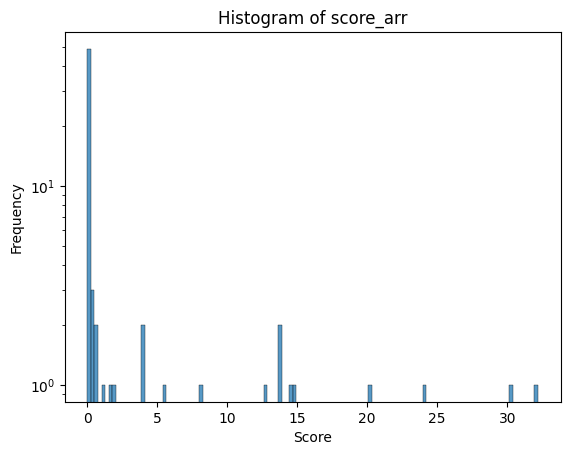

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram using seaborn
sns.histplot(scores_list)

# Set plot title and labels
plt.title("Histogram of score_arr")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.yscale('log')

# Show the plot
plt.show()

# Save the plot to disk
# plt.savefig(f'select_datasets/{LANG_CODE}/rouge{DSETSIZE}/score_dist.png')


---
# graveyard

In [ ]:
def ngram_overlap_score(source: str, example: list[str]) -> float:
    from nltk.translate.bleu_score import (SmoothingFunction, sentence_bleu,)

    hypotheses = source.split()
    references = [s.split() for s in example]

    return float(
        sentence_bleu(
            references,
            hypotheses,
            smoothing_function=SmoothingFunction().method1,
            auto_reweigh=True,
        )
    )
 
def select_examples(queries: list[str], example_pool: list[str], threshold = -1.0) -> list[dict]:
    selected_examples = []
    queries_size = len(queries)
    pool_size = len(example_pool)
    print(f"selecting from example pool of size {pool_size}")
    print(f"matching against {queries_size} queries")
    scores = [0.0] * pool_size

    for i in tqdm(range(queries_size)):
        for j in range(pool_size):
            scores[j] += ngram_overlap_score(
                queries[i], [example_pool[j]]
            )

    score_scratch = [s for s in scores]
    while True:
        arg_max = np.argmax(score_scratch)
        if (score_scratch[arg_max] < threshold) or (score_scratch[arg_max] == 0):
            break

        selected_examples.append((score_scratch[arg_max], example_pool[arg_max]))
        score_scratch[arg_max] = threshold - 1.0

    return scores, selected_examples

scores, selected_examples = select_examples(
    queries = queries,
    example_pool = example_pool,
    threshold=0
)

for e in selected_examples:
    print(e)